# Roll the dice! 2 - In Pyro


This is an example of probabilistic programming with dices and bets.
It is a reimplementation in Pyro of the last problem presented in the notebook [Roll the dice!](dice_roll.ipynb)

The idea here is to get a more readable approach using code abstractions.

In [1]:
from collections import defaultdict

import pyro
import torch
import seaborn as sns

In [2]:
sns.set(rc={'figure.figsize':(11.7,8.27)})  # Figure size

## The problem

We roll:
* 3 6-faced dices
* 2 12-faced dices
* A 20-faced dice
* A coin (head sums 1, tails sums 0), but 60% of times we get tails

Which number should we bet?

In [3]:
class Dice:
    
    def __init__(self, faces, probs=None, face_values=None):
        self.faces = faces
        self.probs = torch.ones(faces) if probs is None else probs
        self.face_values = torch.arange(1,1+faces, dtype=torch.float) if face_values is None else face_values
        self.dist = pyro.distributions.Multinomial(probs=self.probs)
        
    def roll(self):
        """Return the value of the rolled dice.
        """
        return pyro.sample("sample", self.dist).dot(self.face_values)

In [4]:
# Define dices

d6 = Dice(6)
d12 = Dice(12)
d20 = Dice(20)
d2 = Dice(
    faces=2,
    probs=torch.tensor([60.,40.]),  # The coin is disbalanced
    face_values=torch.tensor([0., 1.])
)

In [5]:
%%time
n_rolls = 100000
counts = defaultdict(lambda : 0) 

for i in range(n_rolls):
    counts[int((  # Throw the 7 elements!
        d6.roll()  + d6.roll()  + d6.roll() +\
        d12.roll() + d12.roll() +\
        d20.roll() +\
        d2.roll()
    ).item())] += 1

CPU times: user 37 s, sys: 288 ms, total: 37.3 s
Wall time: 37.3 s


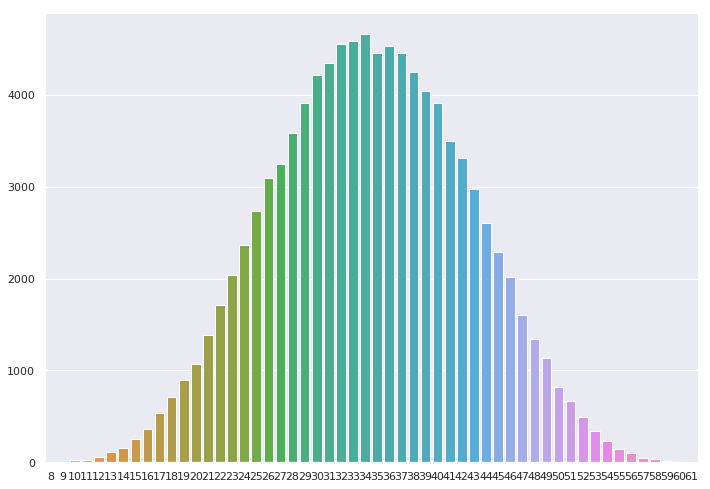

In [6]:
sns.barplot(
    x=list(counts.keys()),
    y=list(counts.values())
)

In [7]:
print("Value\t Probability (%)")
for value, prob in counts.items():
    print(" {}\t {:.8f}".format(value, prob/n_rolls))

Value	 Probability (%)
 8	 0.00001000
 9	 0.00002000
 10	 0.00023000
 11	 0.00027000
 12	 0.00061000
 13	 0.00107000
 14	 0.00159000
 15	 0.00250000
 16	 0.00360000
 17	 0.00532000
 18	 0.00713000
 19	 0.00898000
 20	 0.01069000
 21	 0.01391000
 22	 0.01708000
 23	 0.02040000
 24	 0.02371000
 25	 0.02737000
 26	 0.03095000
 27	 0.03244000
 28	 0.03591000
 29	 0.03913000
 30	 0.04213000
 31	 0.04344000
 32	 0.04559000
 33	 0.04592000
 34	 0.04663000
 35	 0.04459000
 36	 0.04532000
 37	 0.04462000
 38	 0.04247000
 39	 0.04043000
 40	 0.03910000
 41	 0.03498000
 42	 0.03314000
 43	 0.02980000
 44	 0.02603000
 45	 0.02289000
 46	 0.02013000
 47	 0.01604000
 48	 0.01343000
 49	 0.01138000
 50	 0.00817000
 51	 0.00668000
 52	 0.00494000
 53	 0.00346000
 54	 0.00233000
 55	 0.00142000
 56	 0.00103000
 57	 0.00044000
 58	 0.00035000
 59	 0.00013000
 60	 0.00005000
 61	 0.00002000


We can say the results are much similiar, so these approach works as expected.

The less possible value is $6$ and the maximum is $63 = 3*6 + 2*12 + 20 + 1$.
However, we don't see these value as the number of iterations is not high enough.

## Differences

### On efficiency
The execution times are both the same, around 38 seconds. In contrast, this implementation can simulate $10^5$ rolls when the former one could $10^7$ rolls. So the original implementation is 2 orders of magnitude faster.

### On memory
The original implementation is more greed on memory as it stores all the roll history on memory, however this can be changed. This implementation only store the counts so the memory footprint is negligible.

### On readability
I prefer these implementation as is easier to read, tweak, and there are not vectorized operations. But, resources are always limited and this approach should not be used for other purspose than tinkering.


### Notes
1. I am not saying Pyro is slow. This argument has no point since the pyro functions used are only wrappers around the Pytorch ones.
1. The comparison is between a fully vectorized approach (speed) VS an object oriented one (readability).